# Policy iteration

Policy iteration is another way of solving the MDP problem. Instead of learning the optimal state value function, policy iteration starts with a random policy and gradually imporves the policy in two steps

1. Policy evaluation: The value function of the current policy $\pi_k$ is evaluated, and
2. Policy improvement: Update policy $\pi_{k+1}$ to increase the value

## Policy evaluation (E)

In the policy evaluation step, we evaluate the value function $V_{\pi_k}(\mathbf{s})$. By the Bellman equation, we have 

$$V_{\pi_k}(\mathbf{s}) = \sum_{\mathbf{a}} \pi_k(\mathbf{a}|\mathbf{s})\sum_{\mathbf{s}'} p(\mathbf{s}'|\mathbf{s}, \mathbf{a}) [r_0 +  \gamma V_{\pi_k}(\mathbf{s}')] $$

We can estimate $V_{\pi_k}$ using an iterative approach similar to value iteration. The psuedocode is prsented below. Note that the only difference is the update rule.
```{prf:algorithm} Policy-evaluation
:label: simple-algorithm

**Inputs** Given a MDP instance and policy $\pi$.

**Output** Compute the value function $V_{\pi}$ 

1. Initialize an array $V(\mathbf{s})=0$ for all $s\in \mathcal{S}$
2. While not converged
	for all state $\mathbf{s}\in \mathcal{S}$
    
	1. Update $V(\mathbf{s}) \leftarrow \sum_{\mathbf{a}\in \mathcal{A}} \pi(\mathbf{a}|\mathbf{s})\sum_{\mathbf{s}'\in \mathcal{S}} p(\mathbf{s}'|\mathbf{s}, \mathbf{a}) [r_0 +  \gamma V_{\pi}(\mathbf{s}')]$
```

## Policy improvement (I)

In the policy improvement step, we improve the current policy. We consider the state action fucntion $Q_{\pi}(\mathbf{s},\mathbf{a})$. Intuitively, if there exists an action such that 

$$Q_{\pi}(\mathbf{s},\mathbf{a})\geq V_\pi(\mathbf{s})$$

Then we get a better payoff by choosing action $\mathbf{a}$ instead of action $\pi(\mathbf{s})$. This motivates us to update our policy greedily

$$
\begin{align*}
\hat{\pi}(\mathbf{s}) &= \underset{\mathbf{a}}{\text{argmax}}\; Q_{\pi}(\mathbf{s},\mathbf{a})\\
&= \underset{\mathbf{a}}{\text{argmax}}\sum_{\mathbf{s}'\in \mathcal{S}}p(\mathbf{s}'|\mathbf{s}, \mathbf{a})[r+\gamma V_{\pi}(\mathbf{s}')]
\end{align*}
$$

In the following theorem, we prove that the new policy is better, or as good as $\pi$.
````{prf:theorem} Policy improvement lemma
:label: my-theorem

Let $\pi, \hat{\pi}$ be any pair of deterministic policy, if 

$$Q_{\pi}(\mathbf{s}, \hat{\pi}(\mathbf{s}))\geq V_{\pi}(\mathbf{s})\hspace{5mm}\text{for all}\;\mathbf{s}\in \mathcal{S}$$

Then $V_{\hat{\pi}}(\mathbf{s}) \geq V_{\pi}(\mathbf{s})$ for all $\mathbf{s}\in \mathcal{S}$. 

````

````{prf:proof}

Omitted for now.

$$
````

## Policy iteration

The olicy iteration algorithm contains a sequence of evaluation and improvement steps, starting from a random policy $\pi_0$, we update the policy

$$\pi_0 \xrightarrow{\text{E}} q_{\pi_0}  \xrightarrow{\text{I}} \pi_1 \xrightarrow{\text{E}} ....$$

Since, according to policy improvement lemma, $v_{\pi_0}(\mathbf{s})\leq v_{\pi_1}(\mathbf{s})\leq ...v_{\pi_n}(\mathbf{s})$, it follows that the algorithm eventually converges to the policy with the optimal value function $v^*$. The psuedocode for policy iteration is displayed below
```{prf:algorithm} Policy iteration
:label: simple-algorithm

**Inputs** Given a MDP instance and initial policy $\pi_0$

**Output** Policy $\pi^*$ with optimal value function $V^*$

1. While not converged
    
	1. Compute $V_{\pi}(s)$ using policy evaluation algorithm
    2. Update $\pi$ using policy improvement algorithm
```

## Policy iteration Implementation

We now implement the policy iteration algorithm and apply it on the same GridWorld enviroment as before. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GridWorld import *

np.random.seed(0)

In [2]:
def policy_evaluation(grid_world: GridWorld, policy: Policy, max_iter: int, gamma: float=1.0):
    """
    Performs the policy evaluation step
    """
    height, width = grid_world.height, grid_world.width 
    values = np.zeros((width, height))
    for i in range(max_iter):
        for state in grid_world.get_states():
            _, successors = grid_world.get_available_actions(state)
            value = 0
            action = policy[state]
            prob_dist = grid_world.get_transition_prob(state, action)
            for successor, prob in prob_dist.items():
                reward = grid_world.get_reward(state, successor)
                value += prob * (reward + gamma * values[successor[0]][successor[1]])
            values[state[0]][state[1]] = value
    return values

def policy_improvement(grid_world: GridWorld, values: dict, gamma: float):
    """
    Performs a policy improvement step
    """
    height, width = grid_world.height, grid_world.width 
    policy = dict()
    for state in grid_world.get_states():
        available_actions, successors = grid_world.get_available_actions(state)
        q_value = dict()
        for action in available_actions:
            value = 0
            prob_dist = grid_world.get_transition_prob(state, action)
            for successor, prob in prob_dist.items():
                reward = grid_world.get_reward(state, successor)
                value += prob * (reward + gamma * values[successor[0]][successor[1]])
            q_value[action] = value
        policy[state] = max(q_value, key=q_value.get) if len(q_value) > 0 else None
    return policy

def policy_iteration(grid_world: GridWorld, max_iter: int, gamma: float):
    """
    Performs policy iteration
    """
    policy = get_random_policy(grid_world)
    history = [policy]
    for i in range(max_iter):
        values = policy_evaluation(grid_world, policy, max_iter, gamma)
        policy = policy_improvement(grid_world, values, gamma)
        history.append(policy)
    return policy, history

In [ ]:
def get_random_policy(grid_world: GridWorld):
    policy = dict()
    states = grid_world.get_states()
    for state in states:
        available_actions, _ = grid_world.get_available_actions(state)
        random_idx = np.random.choice(np.arange(len(available_actions)))
        policy[state] = available_actions[random_idx]
    return policy

We follow the same setup as before. We ran the policy iteration algorithm for $10$ iterations. We show the learned policy at iteration $0, 4,$ and $9$ below. Note that the algorithm learned the same policy as before. 

In [6]:
height = 5
width = 5
exits = {'good_exit': (3, 1), 'bad_exit': (3, 2)}
walls = [(1, 2)]
rewards = {'living_reward': -0.1, 'win_reward': 1, 'lose_reward': -1}
init_pos = None

grid_world = GridWorld(height, width, exits, walls, rewards, init_pos)
policy, history = policy_iteration(grid_world, max_iter=10, gamma=0.1)

<span style="font-size:20px; font-weight:bold;">Iteration 0</span>

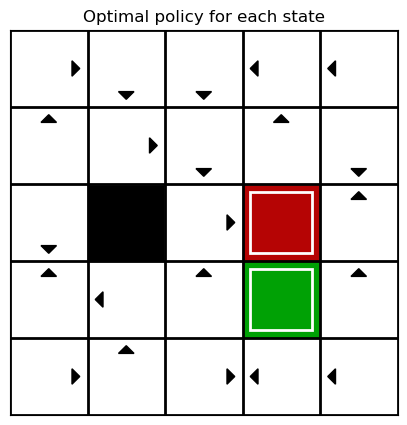

In [8]:
display_policy(grid_world, history[0])

<span style="font-size:20px; font-weight:bold;">Iteration 4</span>

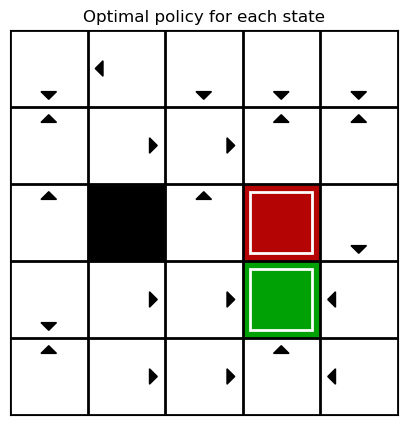

In [9]:
display_policy(grid_world, history[2])

<span style="font-size:20px; font-weight:bold;">Iteration 9</span>

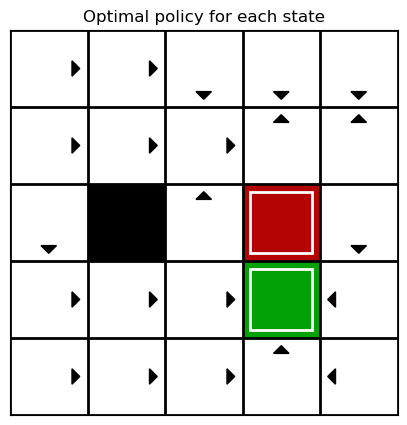

In [10]:
display_policy(grid_world, history[-1])